In [ ]:
# Cell 1 — environment setup
!pip install -q kaggle
!pip install -q tensorflow==2.13.0  # or latest stable TF in Colab
!pip install -q split-folders
!pip install -q opencv-python-headless


ERROR: Could not find a version that satisfies the requirement tensorflow==2.13.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.13.0


In [ ]:
# Cell 2 — imports
import os, shutil, zipfile, random, math
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [ ]:
# STEP 1 — Upload kaggle.json
from google.colab import files
files.upload()   # upload kaggle.json ONLY

# STEP 2 — Move kaggle.json to correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# STEP 3 — Verify Kaggle works
!kaggle datasets list | head

# STEP 4 — Download brain tumor dataset
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

# STEP 5 — Unzip the data
!unzip brain-mri-images-for-brain-tumor-detection.zip


Saving kaggle.json to kaggle.json
ref                                                                title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
shahzadi786/world-smartphone-market-2025                           World Smartphone Market 2025                             17795  2025-11-09 04:52:42.650000           1621         53  1.0              
sadiajavedd/students-academic-performance-dataset                  Students_Academic_Performance_Dataset                     8907  2025-10-23 04:16:35.563000           4089        103  1.0              
ayeshaimran123/social-media-and-mental-health-balance              Social Media and Mental Health Balance                    5941  2025-10-26 07:51:53.380

In [ ]:
# Install splitfolders if not installed
!pip install split-folders
import splitfolders

# Correct dataset path based on YOUR screenshots
input_folder = "/content/brain_tumor_dataset"

# Verify folder exists
!ls -R $input_folder

# Now split into train/val/test sets
splitfolders.ratio(
    input_folder,
    output="/content/split_data",
    seed=42,
    ratio=(0.7, 0.2, 0.1)
)


/content/brain_tumor_dataset:
no  yes

/content/brain_tumor_dataset/no:
'10 no.jpg'  '27 no.jpg'  '42 no.jpg'	 N16.jpg       No14.jpg    'no 8.jpg'
'11 no.jpg'  '28 no.jpg'  '43 no.jpg'	 N17.jpg       No15.jpg    'no 90.jpg'
'12 no.jpg'  '29 no.jpg'   44no.jpg	 N19.JPG       No16.jpg    'no 91.jpeg'
'13 no.jpg'  '2 no.jpeg'  '45 no.jpg'	 N1.JPG        No17.jpg    'no 923.jpg'
'14 no.jpg'  '30 no.jpg'  '46 no.jpg'	 N20.JPG       No18.jpg    'no 92.jpg'
'15 no.jpg'  '31 no.jpg'  '47 no.jpg'	 N21.jpg       No19.jpg    'no 94.jpg'
'17 no.jpg'  '32 no.jpg'  '48 no.jpeg'	 N22.JPG      'no 1.jpg'   'no 95.jpg'
'18 no.jpg'  '33 no.jpg'  '49 no.jpg'	 N26.JPG       No20.jpg    'no 96.jpg'
'19 no.jpg'  '34 no.jpg'  '4 no.jpg'	 N2.JPG        No21.jpg    'no 97.jpg'
'1 no.jpeg'  '35 no.jpg'  '50 no.jpg'	 N3.jpg        No22.jpg    'no 98.jpg'
'20 no.jpg'  '36 no.jpg'  '5 no.jpg'	 N5.jpg       'no 2.jpg'   'no 99.jpg'
'21 no.jpg'  '37 no.jpg'  '6 no.jpg'	 N6.jpg       'no 3.jpg'   'no 9.png'
'22 no.j

Copying files: 253 files [00:00, 6577.20 files/s]


In [ ]:
# Cell 5 — Generators
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_dir = "/content/split_data/train"
val_dir   = "/content/split_data/val"
test_dir  = "/content/split_data/test"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
val_gen   = val_datagen.flow_from_directory(val_dir,   target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
test_gen  = val_datagen.flow_from_directory(test_dir,  target_size=IMG_SIZE, batch_size=1, class_mode='binary', shuffle=False)


Found 176 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


In [ ]:
# Cell 6 — model
base = applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False  # freeze for initial training

inp = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base(inp, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inp, out)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Only reduce learning rate on plateau, no early stopping
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=3,
        factor=0.5,
        monitor='val_loss'
    )
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.5865 - auc: 0.5001 - loss: 0.6735 - val_accuracy: 0.6200 - val_auc: 0.7114 - val_loss: 0.6636 - learning_rate: 1.0000e-04
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - accuracy: 0.6192 - auc: 0.5325 - loss: 0.6694 - val_accuracy: 0.6200 - val_auc: 0.5000 - val_loss: 0.6640 - learning_rate: 1.0000e-04
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.5775 - auc: 0.5042 - loss: 0.6837 - val_accuracy: 0.6200 - val_auc: 0.5000 - val_loss: 0.6635 - learning_rate: 1.0000e-04
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - accuracy: 0.6106 - auc: 0.4818 - loss: 0.6690 - val_accuracy: 0.6200 - val_auc: 0.6570 - val_loss: 0.6633 - learning_rate: 1.0000e-04
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - accuracy: 0.6428 - auc: 0.4949 - loss: 0.6558 - val_accuracy: 0.6200 - val_auc: 0.6570 - val_loss: 0.6636 - learning_rate: 1.0000e-04
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.6709 -

In [ ]:
# Cell 8 — fine-tune
base.trainable = True
# Fine-tune from some layer
fine_tune_at = 150
for layer in base.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
history_fine = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 79s 7s/step - accuracy: 0.4252 - auc: 0.4166 - loss: 0.7267 - val_accuracy: 0.6200 - val_auc: 0.7920 - val_loss: 0.6630 - learning_rate: 1.0000e-05
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.5750 - auc: 0.5618 - loss: 0.6830 - val_accuracy: 0.6200 - val_auc: 0.5968 - val_loss: 0.6631 - learning_rate: 1.0000e-05
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.4861 - auc: 0.4464 - loss: 0.7048 - val_accuracy: 0.6200 - val_auc: 0.6613 - val_loss: 0.6636 - learning_rate: 1.0000e-05
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.4430 - auc: 0.3593 - loss: 0.7281 - val_accuracy: 0.6200 - val_auc: 0.6681 - val_loss: 0.6639 - learning_rate: 1.0000e-05
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.6189 - auc: 0.4929 - loss: 0.6764 - val_accuracy: 0.6200 - val_auc: 0.5645 - val_loss: 0.6653 - learning_rate: 5.0000e-06
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.5979 -

27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step
Accuracy: 0.5925925925925926
Precision: 0.5925925925925926
Recall: 1.0
F1: 0.7441860465116279
AUC: 0.7670454545454546


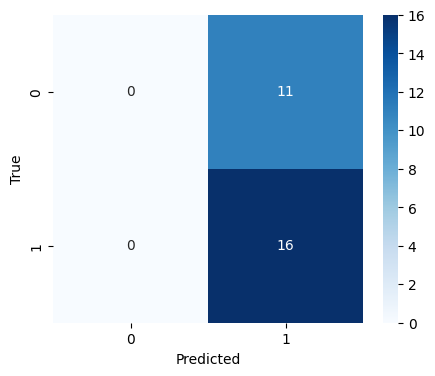

              precision    recall  f1-score   support

          no       0.00      0.00      0.00        11
         yes       0.59      1.00      0.74        16

    accuracy                           0.59        27
   macro avg       0.30      0.50      0.37        27
weighted avg       0.35      0.59      0.44        27



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Cell 9 — evaluation
# predict on test set
y_true = test_gen.classes
test_steps = len(test_gen)
preds = model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = (preds.ravel() >= 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1:", f1_score(y_true, y_pred))
print("AUC:", roc_auc_score(y_true, preds))

# Confusion matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))


In [ ]:
# Cell 11 — save
model.save("/content/brain_tumor_model.h5")
from google.colab import files
files.download("/content/brain_tumor_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving Screenshot 2025-11-14 at 8.59.24 PM.png to Screenshot 2025-11-14 at 8.59.24 PM (4).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


/tmp/ipython-input-1076557973.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_names[int(prediction[0] > 0.6)]  # binary threshold


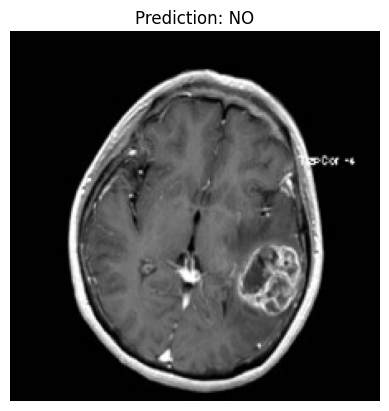

Raw model output: [0.5113432]
Final prediction: no


In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# --------------------------
# Load your trained model
# --------------------------
MODEL_PATH = "/content/brain_tumor_model.h5"
model = load_model(MODEL_PATH)

# Class names as per your dataset (0=no, 1=yes)
class_names = ["no", "yes"]

# --------------------------
# Upload an image
# --------------------------
uploaded = files.upload()

for filename in uploaded.keys():

    # Load and preprocess image (224×224!)
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Prediction
    prediction = model.predict(img_array)
    predicted_class = class_names[int(prediction[0] > 0.6)]  # binary threshold

    # Display result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {predicted_class.upper()}")
    plt.show()

    print("Raw model output:", prediction[0])
    print("Final prediction:", predicted_class)
